# Construct a custom fit for an extension of the MRP: a double-Schechter function.

**Note: this example is almost identical to that found in the R package ``tggd`` in the ``tggd_log`` documentation.**

While ``mrpy`` has several in-built routines which aid in fitting the MRP function to data, it does not natively support fitting *extensions* of the MRP, such as double-Schechter functions. For such functions, one can fairly simply create custom fits using the methods found in Scipy, for example.

In this example, we create a double-Schechter galaxy stellar mass function (GSMF) down to a target stellar mass (xmin) of log10(SM) = 8. We use data from Baldry+2012 to define the function:

Both mixtures have

$$  M_\star \equiv \log_{10} \mathcal{H}_\star = 10.66 $$
and
$$\beta = 1$$

Mixture 1 has:

$$  \alpha_1 = -1.47 $$
$$ \phi^\star_1 = 0.79\times 10^{-3}$$

Mixture 2 has:

$$  \alpha_2 = -0.35 $$
$$ \phi^\star_2 = 3.96\times 10^{-3}$$

Furthermore, we use only the purely statistical routines of ``mrpy`` to achieve our results:

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import minimize

from mrpy.base import stats

First we define objects which capture the statistical quantities of each mixture:

In [2]:
mix1 = stats.TGGDlog(10.66,-1.47,1.0,8)
mix2 = stats.TGGDlog(10.66,-0.35,1.0,8)

$\phi^\star$ is defined as the value of the pdf *in log-space* at the pivot scale by $e$, i.e.

$$ \phi^\star = PDF(M_\star)\times \frac{e}{\ln(10)} $$

This normalisation is important in our sampling since it gives the ratio of samples produced by each mixture. We can produce the relevant normalisation using:

In [3]:
M1norm=0.79/mix1.pdf(10.66)
M2norm=3.96/mix2.pdf(10.66)
Mtot=M1norm+M2norm

Now say we would like to sample 1e5 galaxies, we can produce these like so:

In [4]:
Nsamp=1e5

np.random.seed(100)

mix1_sample = mix1.rvs(int(Nsamp*M1norm/Mtot))
mix2_sample = mix2.rvs(int(Nsamp*M2norm/Mtot))

gal_sample = np.concatenate((mix1_sample,mix2_sample))

Let's plot the distribution we've just created, to check if everything has worked okay:

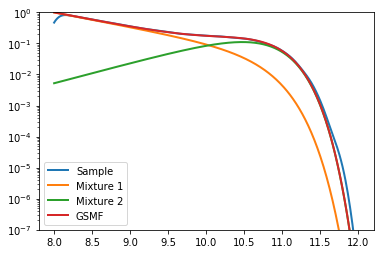

In [5]:
# Create x array to plot against
x = np.linspace(8,12,401)

plt.plot(x,gaussian_kde(gal_sample)(x),label="Sample", lw=2)

plt.plot(x,mix1.pdf(x) * M1norm/Mtot,label="Mixture 1", lw=2)
plt.plot(x,mix2.pdf(x) * M2norm/Mtot,label="Mixture 2", lw=2)
plt.plot(x,mix1.pdf(x) * M1norm/Mtot + mix2.pdf(x) * M2norm/Mtot, label="GSMF", lw=2)
plt.yscale('log')
plt.ylim((1e-7,1))
plt.legend(loc=0)

Now we can try to fit the mixed model. The trick here is we fit for the mixture using an additional parameter $\lambda$, where one component is multiplied by $\lambda$ and the other $1-\lambda$. We define it so that ``M1norm/Mtot=lambda`` and ``M1norm/Mtot=1-lambda``. Here's our model:

In [6]:
def mix_lnl(par,data):
    mix1 = stats.TGGDlog(par[0],par[1],1.0,8)
    mix2 = stats.TGGDlog(par[0],par[2],1.0,8)
    
    return -np.sum(np.log(mix1.pdf(data)*par[3] + mix2.pdf(data)*(1-par[3])))

Now we can perform the fit, using a downhill-gradient method of our choice. The fit is probably not fantastic though. Generalised Gamma distributions (including truncated ones) display poor convergence properties using ML. Full MCMC is a better route when trying to fit GSMF type data. And the data certainly should *not* be binned!

In [7]:
GSMFfit = minimize(mix_lnl, x0=[10,-2,0,0.5], args=(gal_sample,), bounds=[(9,12),(-2.5,-0.5),(-1.0,0.5),(0.0,1.0)])

print "Maximum likelihood parameters: ", GSMFfit.x 

Maximum likelihood parameters:  [ 10.65427592  -1.46844631  -0.34935003   0.83445411]


This accords very well with our input parameters!